# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>attention</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

HW Writeup: [TODO] <br>
Kaggle Competition Link: https://www.kaggle.com/competitions/attention-based-speech-recognition <br>
Kaggle Dataset Link: https://www.kaggle.com/competitions/attention-based-speech-recognition/data
<br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

## README

The ASR system is designed to convert spoken language into written text using deep learning techniques. The provided code includes the implementation of the ASR model, training and validation procedures, and data loading mechanisms.

* To run this code, you will need to first fill in your Kaggle and WandB credentials.
* Run the notebook in a chronological order

## Data Loading

* The data loading process is handled by the `SpeechDatasetME` and `SpeechDatasetTest` classes.
* These classes load the MFCC features and transcripts for training and testing, respectively.
* The data is efficiently loaded in a memory-efficient manner.

## Configurations

* batch_size: 96.
* epochs: 140.
* learning_rate: 2e-4.
* weight_decay: 5e-3
* Teacher forcing rate: 1.0
* Optimizer: AdamW optimizer 
* Scheduler: CosineAnnealingLR
* Loss Function: CrossEntropyLoss
* Levenshtein distance

## Model Architecture

The ASR model consists of three main components:

- **Listener (Encoder):** A Transformer-based listener processes the input speech features.
* Hidden Size: 256
* embedding:  Conv1d, BatchNorm1d, GELU, Conv1d

- **Attention Mechanism:** The attention mechanism computes context vectors based on encoder outputs.
* Listener Hidden Size: 256
* Speller Hidden Size: 256
* Projection Size: 256
- **Speller (Decoder):** The speller generates transcriptions using the attention context.
* Vocabulary Size: 31
* Embedding Size: 580
* Projection Size: 256
* Speller Size: 256

This gave me the validation distance of 12.083 and 10.96946 on Kaggle

# Read this section importantly!

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. You are allowed to use code from your previous homeworks for this homework. We will only provide, aspects that are necessary and new with this homework.

3. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [ ]:
!nvidia-smi

Wed Nov 29 16:18:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb kaggle pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 16.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchaudio
from torch import nn, Tensor
# import torchsummary

import numpy as np
import os

import gc
import time

import pandas as pd
from tqdm.notebook import tqdm as blue_tqdm
import matplotlib.pyplot as plt
import seaborn
import json

import math
from typing import Optional, List


#imports for decoding and distance calculation
try:
    import wandb
    import torchsummaryX
    import Levenshtein
except:
    print("Didnt install some/all imports")

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


# Config

In [ ]:
config = dict (
    train_dataset       = 'train-clean-360', # train-clean-100, train-clean-360, train-clean-460
    batch_size          = 96,
    epochs              = 100,
    learning_rate       = 2e-4,
    weight_decay        = 5e-3,
    cepstral_norm       = True,
)

# Kaggle Dataset Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"gbwiraye","key":"Key"}')

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# # to download the dataset
!kaggle competitions download -c attention-based-speech-recognition

# # to unzip data quickly and quietly
!unzip -q attention-based-speech-recognition.zip -d ./dataSpeech

100% 16.6G/16.6G [01:07<00:00, 274MB/s]
100% 16.6G/16.6G [01:07<00:00, 266MB/s]


# Character-based LibriSpeech (HW4P2)

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required??

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2?
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [ ]:
VOCAB = [
    '<pad>', '<sos>', '<eos>',
    'A',   'B',    'C',    'D',
    'E',   'F',    'G',    'H',
    'I',   'J',    'K',    'L',
    'M',   'N',    'O',    'P',
    'Q',   'R',    'S',    'T',
    'U',   'V',    'W',    'X',
    'Y',   'Z',    "'",    ' ',
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab : {len(VOCAB)}")
print(f"Vocab           : {VOCAB}")
print(f"PAD_TOKEN       : {PAD_TOKEN}")
print(f"SOS_TOKEN       : {SOS_TOKEN}")
print(f"EOS_TOKEN       : {EOS_TOKEN}")

Length of vocab : 31
Vocab           : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN       : 0
SOS_TOKEN       : 1
EOS_TOKEN       : 2


In [ ]:
len(VOCAB_MAP)

31

In [ ]:
VOCAB_MAP[" "]

30

In [ ]:
class SpeechDatasetME(torch.utils.data.Dataset): # Memory efficient
    # Loads the data in get item to save RAM

    def __init__(self, root, partition= "train-clean-360", transforms = None, cepstral=True):

        self.VOCAB      = VOCAB
        self.cepstral   = cepstral

        if partition == "train-clean-100" or partition == "train-clean-360":
            mfcc_dir       = str(f"{root}{partition}/mfcc/")# path to the mfccs
            transcript_dir = str(f"{root}{partition}/transcripts/")# path to the transcripts

            mfcc_files          = [mfcc_dir+i for i in sorted(os.listdir(mfcc_dir))]# create a list of paths for all the mfccs in the mfcc directory
            transcript_files    = [transcript_dir+i for i in sorted(os.listdir(transcript_dir))]# create a list of paths for all the transcripts in the transcript directory

        else:
            mfcc_dir       = str(f"{root}train-clean-100/mfcc/")# path to the mfccs in the train clean 100 partition
            transcript_dir = str(f"{root}train-clean-100/transcripts/")# path to the transcripts in the train clean 100 partition

            mfcc_files          = [mfcc_dir+i for i in sorted(os.listdir(mfcc_dir))]# create a list of paths for all the mfccs in the mfcc directory
            transcript_files    = [transcript_dir+i for i in sorted(os.listdir(transcript_dir))]# create a list of paths for all the transcripts in the transcript directory

            mfcc_dir       = str(f"{root}train-clean-360/mfcc/")# path to the mfccs in the train clean 360 partition
            transcript_dir = str(f"{root}train-clean-360/transcripts/")# path to the transcripts in the train clean 100 partition

            # add the list of mfcc and transcript paths from train-clean-360 to the list of paths  from train-clean-100
            # TODO

            mfcc_files          += [mfcc_dir+i for i in sorted(os.listdir(mfcc_dir))]# create a list of paths for all the mfccs in the mfcc directory
            transcript_files    += [transcript_dir+i for i in sorted(os.listdir(transcript_dir))]# create a list of paths for all the transcripts in the transcript directory


        assert len(mfcc_files) == len(transcript_files)
        length = len(mfcc_files)# TODO

        self.mfcc_files         = mfcc_files
        self.transcript_files   = transcript_files
        self.length             = len(transcript_files)
        print("Loaded file paths ME: ", partition)


    def __len__(self):
        return self.length# TODO

    def __getitem__(self, ind):

        # Load the mfcc and transcripts from the mfcc and transcript paths created earlier
        mfcc        = np.load(self.mfcc_files[ind])# TODO
        transcript  = np.load(self.transcript_files[ind])# TODO

        # Normalize the mfccs and map the transcripts to integers
        mfcc                = (mfcc - mfcc.mean(axis=0))/mfcc.std(axis=0)# TODO
        transcript_mapped   = [VOCAB_MAP[trans_idx] for trans_idx in transcript]# TODO

        return torch.FloatTensor(mfcc), torch.LongTensor(transcript_mapped)

    def collate_fn(self,batch):

        batch_x, batch_y, lengths_x, lengths_y = [], [], [], []

        for x, y in batch:
            # Add the mfcc, transcripts and their lengths to the lists created above
            # TODO
            batch_x.append(x)
            batch_y.append(y)
            lengths_x.append(len(x))
            lengths_y.append(len(y))

        # pack the mfccs and transcripts using the pad_sequence function from pytorch
        batch_x_pad = pad_sequence(batch_x, batch_first=True)# TODO
        batch_y_pad = pad_sequence(batch_y, batch_first=True)# TODO

        return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)


In [ ]:
class SpeechDatasetTest(torch.utils.data.Dataset):

    def __init__(self, root, partition, cepstral=False):

        self.mfcc_dir   = str(f"{root}{partition}/mfcc/")# path to the test-clean mfccs
        self.mfcc_files = sorted(os.listdir(self.mfcc_dir))# list files in the mfcc directory

        self.mfccs = []
        for i, filename in enumerate(blue_tqdm(self.mfcc_files)):
            mfcc = np.load(self.mfcc_dir+filename)# load the mfccs
            if cepstral:
                # Normalize the mfccs
                mfcc = (mfcc - mfcc.mean(axis=0))/mfcc.std(axis=0)# TODO
            # append the mfcc to the mfcc list created earlier
            self.mfccs.append(mfcc)

        self.length = len(self.mfccs)
        print("Loaded: ", partition)

    def __len__(self):
        # TODO
        return self.length
    def __getitem__(self, ind):
        # TODO
        return torch.FloatTensor(self.mfccs[ind])

    def collate_fn(self,batch):

        batch_x, lengths_x = [], []
        for x in batch:
            # Append the mfccs and their lengths to the lists created above
            batch_x.append(x)
            lengths_x.append(len(x))
        # pack the mfccs using the pad_sequence function from pytorch
        batch_x_pad = pad_sequence(batch_x, batch_first=True)# TODO

        return batch_x_pad, torch.tensor(lengths_x)

In [ ]:
DATA_DIR        = '/content/dataSpeech/11-785-f23-hw4p2/'
PARTITION       = config['train_dataset']
CEPSTRAL        = config['cepstral_norm']

train_dataset   = SpeechDatasetME( # Or AudioDatasetME
    root        = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL
)
valid_dataset   = SpeechDatasetME(
    root        = DATA_DIR,
    partition   = 'dev-clean',
    cepstral    = CEPSTRAL
)
test_dataset    = SpeechDatasetTest(
    root        = DATA_DIR,
    partition   = 'test-clean',
    cepstral    = CEPSTRAL,
)

gc.collect()

In [ ]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

valid_loader    = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = valid_dataset.collate_fn
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn
)

print("No. of train mfccs   : ", train_dataset.__len__())
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Valid batches        : ", valid_loader.__len__())
print("Test batches         : ", test_loader.__len__())

No. of train mfccs   :  104013
Batch size           :  96
Train batches        :  1084
Valid batches        :  1381
Test batches         :  28


In [ ]:
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=5G shm /dev/shm

umount: /dev/shm/: target is busy.


In [ ]:
!sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=5G shm /dev/shm

In [ ]:
print("\nChecking the shapes of the data...")
for batch in train_loader:
    x, y, x_len, y_len = batch
    print(x.shape, y.shape, x_len.shape, y_len.shape)
    print(y)
    break


Checking the shapes of the data...
torch.Size([96, 1629, 28]) torch.Size([96, 295]) torch.Size([96]) torch.Size([96])
tensor([[ 1, 27,  7,  ...,  0,  0,  0],
        [ 1, 25,  3,  ...,  0,  0,  0],
        [ 1, 22, 10,  ...,  0,  0,  0],
        ...,
        [ 1, 10,  7,  ...,  0,  0,  0],
        [ 1, 11, 30,  ...,  0,  0,  0],
        [ 1,  3, 16,  ...,  0,  0,  0]])


In [ ]:
def verify_dataset(dataset, partition= 'train-clean-100'):
    print("\nPartition loaded     : ", partition)
    if partition != 'test-clean':
        print("Max mfcc length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg mfcc length          : ", np.mean([data[0].shape[0] for data in dataset]))
        print("Max transcript length    : ", np.max([data[1].shape[0] for data in dataset]))
        print("Max transcript length    : ", np.mean([data[1].shape[0] for data in dataset]))
    else:
        print("Max mfcc length          : ", np.max([data.shape[0] for data in dataset]))
        print("Avg mfcc length          : ", np.mean([data.shape[0] for data in dataset]))

verify_dataset(train_dataset, partition= 'train-clean-100')
verify_dataset(valid_dataset, partition= 'dev-clean')
verify_dataset(test_dataset, partition= 'test-clean')
dataset_max_len  = max(
    np.max([data[0].shape[0] for data in train_dataset]),
    np.max([data[0].shape[0] for data in valid_dataset]),
    np.max([data.shape[0] for data in test_dataset])
)
print("\nMax Length: ", dataset_max_len)


Partition loaded     :  train-clean-100
Max mfcc length          :  2969
Avg mfcc length          :  1254.208560468403
Max transcript length    :  526
Max transcript length    :  185.8335977233615

Partition loaded     :  dev-clean
Max mfcc length          :  2969
Avg mfcc length          :  1256.451445470457
Max transcript length    :  526
Max transcript length    :  186.01006397489286

Partition loaded     :  test-clean
Max mfcc length          :  3491
Avg mfcc length          :  738.2206106870229

Max Length:  3491


Check if you are loading the data correctly with the following:

- Train Dataset
```
Partition loaded:  train-clean-100
Max mfcc length:  2448
Average mfcc length:  1264.6258453344547
Max transcript:  400
Average transcript length:  186.65321139493324
```

- Dev Dataset
```
Partition loaded:  dev-clean
Max mfcc length:  3260
Average mfcc length:  713.3570107288198
Max transcript:  518
Average transcript length:  108.71698113207547
```

- Test Dataset
```
Partition loaded:  test-clean
Max mfcc length:  3491
Average mfcc length:  738.2206106870229
```

If your values is not matching, read hints, think what could have gone wrong. Then approach TAs.

# THE MODEL

### Listen, Attend and Spell
Listen, Attend and Spell (LAS) is a neural network model used for speech recognition and synthesis tasks.

- LAS is designed to handle long input sequences and is robust to noisy speech signals.
- LAS is known for its high accuracy and ability to improve over time with additional training data.
- It consists of an <b>listener, an attender and a speller</b>, which work together to convert an input speech signal into a corresponding output text.

#### The Dataflow:
<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/DataFlow.png" alt="data flow" height="100">
</center>

#### The Listener:
- converts the input speech signal into a sequence of hidden states.

#### The Attender:
- Decides how the sequence of Encoder hidden state is propogated to decoder.

#### The Speller:
- A language model, that incorporates the "context of attender"(output of attender) to predict sequence of words.






## Utils


In [ ]:
class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

def save_model(model, optimizer, scheduler, tf_scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'tf_scheduler'             : tf_scheduler,
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(best_path, epoch_path, model, mode= 'best', metric= 'valid_acc', optimizer= None, scheduler= None, tf_scheduler= None):


    if mode == 'best':
        checkpoint  = torch.load(best_path)
        print("Loading best checkpoint: ", checkpoint[metric])
    else:
        checkpoint  = torch.load(epoch_path)
        print("Loading epoch checkpoint: ", checkpoint[metric])

    model.load_state_dict(checkpoint['model_state_dict'], strict= False)

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        optimizer.param_groups[0]['weight_decay'] = 1e-5
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if tf_scheduler != None:
        tf_scheduler    = checkpoint['tf_scheduler']

    epoch   = checkpoint['epoch']
    metric  = torch.load(best_path)[metric]

    return [model, optimizer, scheduler, tf_scheduler, epoch, metric]

class TimeElapsed():
    def __init__(self):
        self.start  = -1

    def time_elapsed(self):
        if self.start == -1:
            self.start = time.time()
        else:
            end = time.time() - self.start
            hrs, rem    = divmod(end, 3600)
            min, sec    = divmod(rem, 60)
            min         = min + 60*hrs
            print("Time Elapsed: {:0>2}:{:02}".format(int(min),int(sec)))
            self.start  = -1

## Modules

# Transformer Encoder

In [ ]:
import math

class PositionalEncoding(torch.nn.Module):
    def __init__(self, projection_size, max_seq_len=4000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=0.1)
        self.projection_size = projection_size
        self.max_seq_len = max_seq_len

        # Calculate the positional encoding matrix
        pe = torch.zeros(max_seq_len, projection_size)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, projection_size, 2).float() * (-math.log(10000.0) / projection_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:,:seq_len, :]
        return self.dropout(x)


class TransformerEncoder(torch.nn.Module):
    def __init__(self, projection_size, num_heads, dropout=0.0):
        super().__init__()

        # create the key, query and value weights
        self.KW = torch.nn.Linear(projection_size, projection_size)
        self.VW = torch.nn.Linear(projection_size, projection_size)
        self.QW = torch.nn.Linear(projection_size, projection_size)

        self.permute    = PermuteBlock() # we do not know what it is doing here.

        # Compute multihead attention. You are free to use the version provided by pytorch
        self.attention = torch.nn.MultiheadAttention(projection_size, num_heads, dropout=dropout)

        self.bn1 = torch.nn.BatchNorm1d(projection_size)
        self.bn2 = torch.nn.BatchNorm1d(projection_size)

        # Feed forward neural network
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(projection_size, projection_size),
            torch.nn.ReLU(),
            torch.nn.Linear(projection_size, projection_size)
        )

    def forward(self, x):
        # compute the key, query and value
        key = self.KW(x)
        value = self.VW(x)
        query = self.QW(x)

        # compute the output of the attention module
        out1, _ = self.attention(query, key, value)

        # Create a residual connection between the input and the output of the attention module
        out1 = x + out1

        # Apply batch norm to out1
        out1 = self.bn1(out1.transpose(1,2))
        out1 = out1.transpose(1,2)

        # Apply the output of the feed forward network
        out2 = self.MLP(out1)
        # Apply a residual connection between the input and output of the  FFN
        out2 = out1 + out2
        # Apply batch norm to the output
        out2 = self.bn2(out2.transpose(1,2))
        out2 = out2.transpose(1,2)
        return out2


model   = TransformerEncoder(
    projection_size  = 128, num_heads=4
).to(DEVICE)


print(model)

x_sample    = torch.rand(128, 176, 256)
# torchsummaryX.summary(model, x_sample.to(DEVICE))
del x_sample

TransformerEncoder(
  (KW): Linear(in_features=128, out_features=128, bias=True)
  (VW): Linear(in_features=128, out_features=128, bias=True)
  (QW): Linear(in_features=128, out_features=128, bias=True)
  (permute): PermuteBlock()
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MLP): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)


In [ ]:
class pBLSTM(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=1):
        super(pBLSTM, self).__init__()

        self.blstm = nn.LSTM(input_size =input_size*2, hidden_size = hidden_size,
                             num_layers = num_layers,
                             batch_first = True, dropout = 0.18, bidirectional = True) # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size


    def forward(self, x_packed):
        x, seq_length = pad_packed_sequence(x_packed, batch_first = True, padding_value = PAD_TOKEN)
        x_downsampled, x_lens = self.trunc_reshape(x, seq_length)
        x_down_packed = pack_padded_sequence(x_downsampled, x_lens, batch_first = True, enforce_sorted = False)
        output, _ = self.blstm(x_down_packed)
        return output, x_lens

    def trunc_reshape(self, x, x_lens):
        batch_size, t_step, feature_dim = x.shape

        if t_step % 2 != 0:
          x = x[:,:-1,:]
          t_step -= 1

        x = x.reshape((batch_size, int(t_step/2), feature_dim*2))
        x_lens = x_lens//2
        return x, x_lens

In [ ]:
class TransformerListener(torch.nn.Module):

    def __init__(self,
                 input_size,
                 base_lstm_layers        = 1,
                 pblstm_layers           = 1,
                 listener_hidden_size    = 256,
                 n_heads                 = 8,
                 tf_blocks               = 1):
        super().__init__()

        # create an lstm layer
        self.base_lstm      = pBLSTM(input_size = input_size,
                                     num_layers = base_lstm_layers,
                                     hidden_size = listener_hidden_size)# TODO

        # create a sequence of Conv1d layers
        self.embedding      = torch.nn.Sequential(
              torch.nn.Conv1d(in_channels=listener_hidden_size*2,out_channels=listener_hidden_size,kernel_size=5,padding=2),
              torch.nn.BatchNorm1d(listener_hidden_size),
              torch.nn.GELU(),
              torch.nn.Conv1d(in_channels=listener_hidden_size,out_channels= listener_hidden_size,kernel_size=5,padding=2)
              )# TODO

        # compute the postion encoding
        self.positional_encoding    = PositionalEncoding(projection_size=listener_hidden_size)# TODO

        # create a sequence of transformer blocks
        self.transformer_encoder    = torch.nn.Sequential(
            *[TransformerEncoder(projection_size=listener_hidden_size, num_heads =  n_heads) for _ in range(tf_blocks)]
        )
        
    def forward(self, x, x_len):

        # pack the inputs before passing them to the LSTm
        x_packed                = pack_padded_sequence(x,x_len, batch_first=True, enforce_sorted = False) # TODO
        # Pass the packed sequence through the lstm
        lstm_out, _             = self.base_lstm(x_packed)# TODO
        # Unpack the output of the lstm
        output, output_lengths  = pad_packed_sequence(lstm_out, batch_first=True)# TODO

        # Pass the output through the embedding
        output                  = self.embedding(output.transpose(1,2)).transpose(1,2)# TODO
        # calculate the new output length
        output_lengths          = output_lengths//2# TODO

        # calculate the position encoding
        output  = self.positional_encoding(output)# TODO
        # Pass the output of the positional encoding through the transformer encoder
        output  = self.transformer_encoder(output)# TODO

        return output, output_lengths

# Attention

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query)
    * Optional: Scaled dot-product by normalizing with sqrt key dimension
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

Pseudocode:

```python
class Attention:
    '''
    Attention is calculated using the key, value (from encoder embeddings) and query from decoder.

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    attention_weights   = softmax(raw_weights)
    attention_context   = einsum("thinkwhatwouldbetheequationhere",attention, value) #take hint from raw_weights calculation

    At the end, you can pass context through a linear layer too.
    '''

    def init(listener_hidden_size,
              speller_hidden_size,
              projection_size):

        VW = Linear(listener_hidden_size,projection_size)
        KW = Linear(listener_hidden_size,projection_size)
        QW = Linear(speller_hidden_size,projection_size)

    def set_key_value(encoder_outputs):
        '''
        In this function we take the encoder embeddings and make key and values from it.
        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        '''
        key = KW(encoder_outputs)
        value = VW(encoder_outputs)
      
    def compute_context(decoder_context):
        '''
        In this function from decoder context, we make the query, and then we
         multiply the queries with the keys to find the attention logits,
         finally we take a softmax to calculate attention energy which gets
         multiplied to the generted values and then gets summed.

        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        query.shape = (batch_size, projection_size)

        You are also recomended to check out Abu's Lecture 19 to understand Attention better.
        '''
        query = QW(decoder_context) #(batch_size, projection_size)

        raw_weights = #using bmm or einsum. We need to perform batch matrix multiplication. It is important you do this step correctly.
        #What will be the shape of raw_weights?

        attention_weights = #What makes raw_weights -> attention_weights

        attention_context = #Multiply attention weights to values

        return attention_context, attention_weights
```

In [ ]:
class Attention(torch.nn.Module):
  def __init__(self,
        listener_hidden_size,
        speller_hidden_size,
        projection_size):
    super().__init__()
    self.KW = torch.nn.Linear(listener_hidden_size, projection_size)
    self.VW = torch.nn.Linear(listener_hidden_size, projection_size)
    self.QW = torch.nn.Linear(listener_hidden_size, projection_size)

    self.softmax = nn.Softmax()


  def set_key_value(self, encoder_outputs):

    self.key = self.KW(encoder_outputs)
    self.value = self.VW(encoder_outputs)

  def compute_context(self, decoder_context):
    self.query = self.QW(decoder_context)
    self.query = torch.unsqueeze(self.query,2)
    length_q = self.query.shape[1]
    
    raw_weights = torch.bmm(self.key, self.query).squeeze()
    attention_weights = self.softmax(raw_weights/np.sqrt(length_q))
    attention_context = torch.einsum('bi,bij->bj', attention_weights,self.value)

    return attention_context, attention_weights

# The Speller

Similar to the language model that you coded up for HW4P1, you have to code a language model for HW4P2 as well. This time, we will also call the attention context step, within the decoder to get the attended-encoder-embeddings.


What you have coded till now:

<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/EncoderAttention.png" alt="data flow" height="400">
</center>

For the Speller, what we have to code:


<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/Decoder.png" alt="data flow" height="400">
</center>

In [ ]:
class Speller(torch.nn.Module):

  # Refer to your HW4P1 implementation for help with setting up the language model.
  # The only thing you need to implement on top of your HW4P1 model is the attention module and teacher forcing.

  def __init__(self,vocab_size, embedding_size, projection_size, speller_size,  attender:Attention):
    super(). __init__()

    self.projection_size = projection_size
    self.attend = attender # Attention object in speller
    self.max_timesteps = 590# Max timesteps

    lstm_size = embedding_size+projection_size
    self.embedding =  torch.nn.Embedding(vocab_size, embedding_size) # Embedding layer to convert token to latent space
    self.lstm_cells =  torch.nn.Sequential(
            torch.nn.LSTMCell(lstm_size, speller_size),
            torch.nn.LSTMCell(speller_size, speller_size),
            torch.nn.LSTMCell(speller_size, speller_size)
        )# Create a sequence of LSTM Cells

    # For CDN (Feel free to change)
    self.output_to_char = torch.nn.Linear(speller_size+projection_size, embedding_size)# Linear module to convert outputs to correct hidden size (Optional: TO make dimensions match)
    self.activation = torch.nn.GELU()# Check which activation is suggested
    self.char_prob = torch.nn.Linear(embedding_size, vocab_size)# Linear layer to convert hidden space back to logits for token classification
    self.char_prob.weight = self.embedding.weight# Weight tying (From embedding layer)
    self.drop = torch.nn.Dropout(p=0.21)

  def lstm_step(self, input_word, hidden_state):

    embedding =  input_word

    for i in range(len(self.lstm_cells)):
        embedding, cell_state = self.lstm_cells[i](embedding,hidden_state[i]) # Feed the input through each LSTM Cell


        embedding = self.drop(embedding)
        hidden_state[i] = (embedding, cell_state)

    return embedding, hidden_state # What information does forward() need?


  def CDN(self,input):
    # Make the CDN here, you can add the output-to-char
    out = self.activation(self.output_to_char(self.drop(input)))
    out = self.char_prob(out)
    return out

  def forward (self, y=None, teacher_forcing_ratio=1, encoder_batch_size=x.shape[0]):

    batch_size = encoder_batch_size 
    attn_context = torch.zeros(batch_size, self.projection_size).to(DEVICE)# initial context tensor for time t = 0
    output_symbol = torch.full((batch_size,), SOS_TOKEN).to(DEVICE)# Set it to SOS for time t = 0
    raw_outputs = []
    attention_plot = []

    if y is None:
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0 #Why does it become zero?

    else:
      timesteps = y.shape[1] # How many timesteps are we predicting for?

    hidden_states_list = [None] * len(self.lstm_cells)# Initialize your hidden_states list here similar to HW4P1

    for t in range(timesteps):
      p = np.random.uniform(0,1)# generate a probability p between 0 and 1

      if p < teacher_forcing_ratio and t > 0: # Why do we consider cases only when t > 0? What is considered when t == 0? Think.
        output_symbol = y[:,t-1] # Take from y, else draw from probability distribution


      char_embed = self.embedding(output_symbol) # Embed the character symbol

      # Concatenate the character embedding and context from attention, as shown in the diagram
      lstm_input = torch.cat((char_embed,attn_context), dim = 1)

      lstm_out, hidden_states_list = self.lstm_step(lstm_input, hidden_states_list) # Feed the input through LSTM Cells and attention.
      # What should we retrieve from forward_step to prepare for the next timestep?

      attn_context, attn_weights = self.attend.compute_context(lstm_out) # Feed the resulting hidden state into attention

      cdn_input = torch.cat((lstm_out,attn_context), dim = 1)# TODO: You need to concatenate the context from the attention module with the LSTM output hidden state, as shown in the diagram

      raw_pred = self.CDN(cdn_input) # call CDN with cdn_input

      # Generate a prediction for this timestep and collect it in output_symbols
      output_symbol =  torch.argmax(raw_pred, dim = 1)# Draw correctly from raw_pred

      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights) # for plotting attention plot


    attention_plot = torch.stack(attention_plot, dim=1)
    raw_outputs = torch.stack(raw_outputs, dim=1)

    return raw_outputs, attention_plot

In [ ]:
class ASRModel(torch.nn.Module):
  def __init__(self, vocab_size, embedding_size, input_size, encoder_hidden_size, listener_size, speller_size, projection_size, name="ASR"): # add parameters
    super().__init__()

    # Pass the right parameters here
    self.listener = TransformerListener(input_size, listener_hidden_size=encoder_hidden_size)
    self.attend = Attention(listener_size, speller_size, projection_size)
    self.speller = Speller(vocab_size, embedding_size, projection_size, speller_size, self.attend)
    self.name = name

  def forward(self, x,lx,y=None,teacher_forcing_ratio=1):
    # Encode speech features
    encoder_outputs, _ = self.listener(x,lx)

    # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
    # Set keys and values using the encoder outputs
    self.attend.set_key_value(encoder_outputs)

    # Decode text with the speller using context from the attention
    raw_outputs, attention_plots = self.speller(y=y,teacher_forcing_ratio=teacher_forcing_ratio,
                                                encoder_batch_size = encoder_outputs.shape[0])

    return raw_outputs, attention_plots

# Model Setup

In [ ]:
torch.cuda.empty_cache()
gc.collect()

11

In [ ]:
model = ASRModel(

    # Initialize your model
    vocab_size=31,
    embedding_size=580,
    input_size=28,
    encoder_hidden_size=256,
    listener_size = 256,
    speller_size = 256,
    projection_size = 256
)

model = model.to(DEVICE)
print(model)

ASRModel(
  (listener): TransformerListener(
    (base_lstm): pBLSTM(
      (blstm): LSTM(56, 256, batch_first=True, dropout=0.18, bidirectional=True)
    )
    (embedding): Sequential(
      (0): Conv1d(512, 256, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=(2,))
    )
    (positional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): Sequential(
      (0): TransformerEncoder(
        (KW): Linear(in_features=256, out_features=256, bias=True)
        (VW): Linear(in_features=256, out_features=256, bias=True)
        (QW): Linear(in_features=256, out_features=256, bias=True)
        (permute): PermuteBlock()
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256,

# Loss Function, Optimizers, Scheduler

In [ ]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['learning_rate'])

criterion   = torch.nn.CrossEntropyLoss(reduction='mean',ignore_index=PAD_TOKEN)

scaler      = torch.cuda.amp.GradScaler()

scheduler   = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 70, eta_min = 0.000001)


# Levenshtein Distance

In [ ]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, y_len, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx,0:y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset
        # dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example:
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist    /= batch_size
    return dist

# Train and Validation functions


In [ ]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = blue_tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):
        # if i < 1083: #for debugging purposes
        #   continue

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            raw_predictions, attention_plot = model(x, lx, y = y, teacher_forcing_ratio= teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size).
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # Also we recommend you plot the attention weights, you should get convergence in around 10 epochs, if not, there could be something wrong with
            # your implementation


            raw_predictions = torch.permute(raw_predictions, (0,2,1))
            loss        =  criterion(raw_predictions, y)# TODO: Cross Entropy Loss

            perplexity  = torch.exp(loss) # Perplexity is defined the exponential of the loss

            running_loss        += loss.item()
            running_perplexity  += perplexity.item()

        # Backward on the masked loss
        scaler.scale(loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping

        scaler.step(optimizer)
        scaler.update()


        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()

    return running_loss, running_perplexity, attention_plot

In [ ]:
def validate(model, dataloader):

    model.eval()

    batch_bar = blue_tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0
    my_count = 0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        if i%500 != 0: #for debugging purposes
          continue
        my_count += 1
        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding
        print(i,"a",end="\r")
        greedy_predictions   =  torch.argmax(raw_predictions, dim=2)# TODO: How do you get the most likely character from each distribution in the batch?

        print(i,"a**********",end="\r")
        # Calculate Levenshtein Distance
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = False) # You can use print_example = True for one specific index i in your batches if you want

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= my_count 

    return running_lev_dist

# Wandb


In [ ]:
# Login to Wandb
# Initialize your Wandb Run Here
import wandb
wandb.login(key="API Key")
# Initialize your Wandb Run Here
run = wandb.init(
    name = "Run-1",
    # reinit = True,
    id = "br3hzdbk",
    resume = "must",
    project = "hw4p2-ablations",
    config = config
)

In [ ]:
# Save your model architecture in a txt file, and save the file to Wandb
model_arch  = str(model)

arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

wandb.save('model_arch.txt')

['/content/wandb/run-20231129_174525-br3hzdbk/files/model_arch.txt']

In [ ]:
def plot_attention(attention):
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

# Experiment


Epoch: 1/6


Train:   0%|          | 0/1084 [00:00<?, ?it/s]

Val:   0%|          | 0/1381 [00:00<?, ?it/s]

	Train Loss 0.0932	 Learning Rate 0.0001964
	Val Dist 15.7639	
	Teacher Forcing Ratio 1.0	


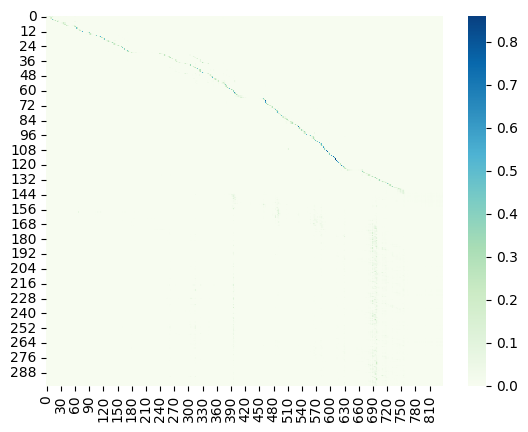


Epoch: 2/6


Train:   0%|          | 0/1084 [00:00<?, ?it/s]

Val:   0%|          | 0/1381 [00:00<?, ?it/s]

	Train Loss 0.1028	 Learning Rate 0.0001975
	Val Dist 12.9896	
	Teacher Forcing Ratio 1.0	


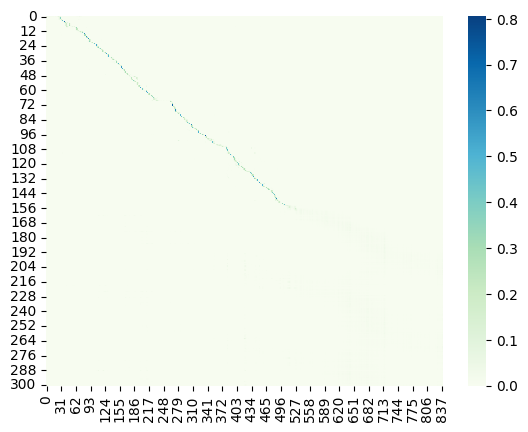


Epoch: 3/6


Train:   0%|          | 0/1084 [00:00<?, ?it/s]

Val:   0%|          | 0/1381 [00:00<?, ?it/s]

	Train Loss 0.0913	 Learning Rate 0.0001984
	Val Dist 15.6597	
	Teacher Forcing Ratio 1.0	


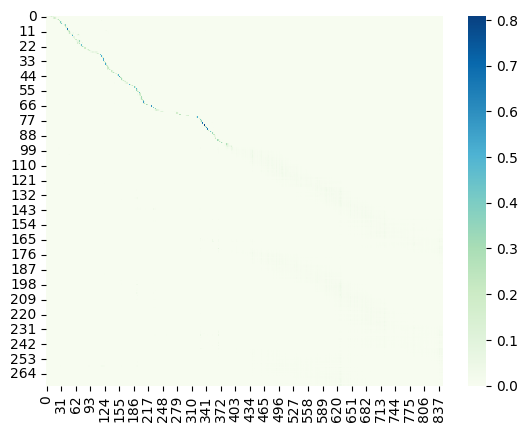


Epoch: 4/6


Train:   0%|          | 0/1084 [00:00<?, ?it/s]

Val:   0%|          | 0/1381 [00:00<?, ?it/s]

	Train Loss 0.0893	 Learning Rate 0.0001991
	Val Dist 12.9410	
	Teacher Forcing Ratio 1.0	


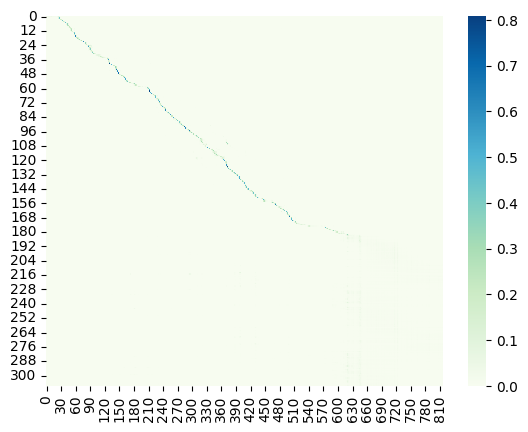


Epoch: 5/6


Train:   0%|          | 0/1084 [00:00<?, ?it/s]

Val:   0%|          | 0/1381 [00:00<?, ?it/s]

	Train Loss 0.0865	 Learning Rate 0.0001996
	Val Dist 12.5104	
	Teacher Forcing Ratio 1.0	


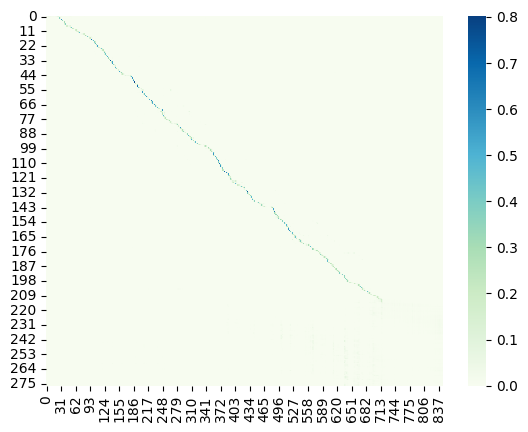

Saved best model

Epoch: 6/6


Train:   0%|          | 0/1084 [00:00<?, ?it/s]

Val:   0%|          | 0/1381 [00:00<?, ?it/s]

	Train Loss 0.0864	 Learning Rate 0.0001999
	Val Dist 12.0833	
	Teacher Forcing Ratio 1.0	


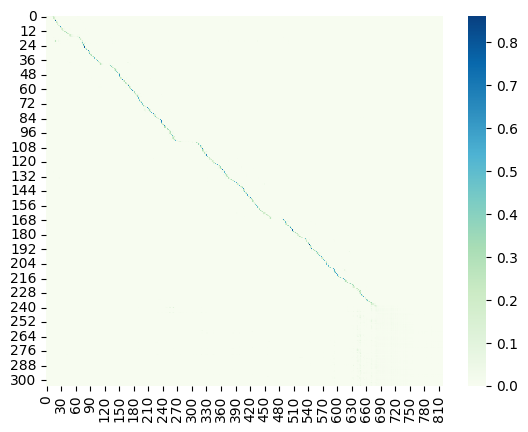

Saved best model


In [89]:
best_lev_dist =  12.8681 #float("inf")
tf_rate = 1.0

for epoch in range(0, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])
    # Call train and validate, get attention weights from training

    train_loss, running_perplexity, attention_plot = train(model,train_loader, criterion, optimizer,tf_rate)
    valid_dist = validate(model, valid_loader)


    # Print your metrics
    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Dist {:.04f}\t".format(valid_dist))
    print("\tTeacher Forcing Ratio {}\t".format(tf_rate))


    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy())

    # Log metrics to Wandb

    wandb.log({
        'train_loss': train_loss,
        'valid_dist': valid_dist,
        'lr'        : curr_lr,
        'tf_ratio'  : tf_rate
    })
    # Optional: Scheduler Step / Teacher Force Schedule Step

    scheduler.step()

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        # Save your model checkpoint here
        save_path = "Run3_model_{0}_{1}_{2}.pth".format(config['learning_rate'],config['batch_size'],model.name)
        save_model(model, optimizer, scheduler, "tf_scheduler",  ['valid_dist', valid_dist], epoch, save_path)
        wandb.save(save_path)
        print("Saved best model")

# Testing

In [90]:
def testing(model, dataloader):

    results = []
    model.eval()

    running_lev_dist = 0.0

    for i, (x,lx) in enumerate(dataloader):

        x, lx = x.to(DEVICE), lx

        with torch.inference_mode():
            raw_predictions, attentions = model(x, lx, y = None)

        greedy_predictions   = torch.argmax(raw_predictions, dim=2)
        del x, lx
        results.extend(greedy_predictions)
    return results

In [95]:
model_dict = torch.load("/content/Run3_model_0.0002_96_ASR.pth")["model_state_dict"]
model.load_state_dict(model_dict)

<All keys matched successfully>

In [96]:
results = testing(model, test_loader)

In [97]:
with open('submission.csv', 'w') as file:
  file.write("index,label\n")
  for i, pred in enumerate(results):
    pred_sliced = indices_to_chars(results[i], VOCAB)
    pred_string = ''.join(pred_sliced)
    file.write(f"{i},{pred_string}\n")

In [98]:
!kaggle competitions submit -c attention-based-speech-recognition -f submission.csv -m "initial sub"

100% 294k/294k [00:02<00:00, 142kB/s]
Successfully submitted to Attention-Based Speech Recognition